# Interpreteren 

ref. https://christophm.github.io/interpretable-ml-book/pixel-attribution.html

## gradient gebaseerd

We gaan PyTorch gebruiken omdat daar handige libraries bestaan om saliency mapping mee toe te passen.

We zullen eerst heel kort een model trainen om de MNIST data te herkennen, jullie hebben vorig jaar bij Machine Learning uitgebreid classificatie besproken, weliswaar in SciKit Learn, maar alles is zeer gelijkaardig.


In [2]:
import torch
import numpy as np

import torchvision
from torchvision import models, transforms, datasets
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import Occlusion, Saliency, IntegratedGradients, DeepLift, DeepLiftShap, GradientShap, LayerGradCam, LayerAttribution, InputXGradient
from captum.attr import visualization as viz
from captum.metrics import infidelity, sensitivity_max
torch.manual_seed(0)

Captum (“comprehension” in Latin) is an open source, extensible library for model interpretability built on PyTorch.

We baseren ons (losjes) op de tutorial https://nextjournal.com/gkoehler/pytorch-mnist om ons model op te bouwen

In [2]:
batch_size_train = 64
batch_size_test = 1000

In [3]:
# Get train and test data
# 0.1307 is de mediaan, 0.3081 standaard deviatie van de MNIST dataset
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
train_set = datasets.MNIST("./datasets", train=True, transform=transform, download=True)
test_set = datasets.MNIST("./datasets", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

Net zoals vorig jaar hebben we een aantal afbeeldingen van 28x28 pixels.

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

1000 voorbeelden, 1 kanaal (enkel grayscale), 28x28 pixels

/var/folders/c2/_h0m04n573df61vwy3gp9gj40000gn/T/ipykernel_71533/1600547208.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


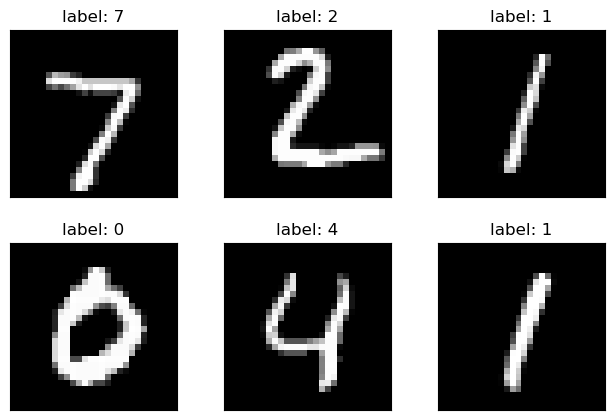

In [5]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# print(example_data[0][0])


De code om een netwerk op te bouwen in PyTorch 

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)

In [8]:
learning_rate = 0.01
momentum = 0.5

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [9]:
n_epochs = 1

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

Deze PyTorch-code is een trainingslus voor een neuraal netwerk met het gebruik van de "Negative Log-Likelihood" (NLL) verliesfunctie. Het model wordt getraind voor een bepaald aantal epochs met behulp van een trainingsdataset en een optimizer.

Hier is een stapsgewijze uitleg van wat de code doet:

   - network.train(): Stelt het model in op trainingsmodus, waarbij functies zoals dropout en batch normalization worden ingeschakeld die specifiek zijn voor training.

   - De trainingslus itereert over de train_loader, die een PyTorch DataLoader bevat met batches van trainingsgegevens en de bijbehorende labels.

   - optimizer.zero_grad(): Maakt de gradients van alle geoptimaliseerde tensors leeg. Dit is nodig voordat de gradients voor de volgende  batch worden berekend.

   - output = network(data): Voert de input data door het network (neuraal netwerkmodel) om de voorspelde uitvoer te verkrijgen.

   - loss = F.nll_loss(output, target): Berekent het negatieve log-likelihood verlies tussen de voorspelde output en de werkelijke target labels. Dit verlies wordt vaak gebruikt voor multi-class classificatieproblemen.

   - loss.backward(): Voert backpropagation uit om gradients te berekenen met betrekking tot de parameters van het model.

   - optimizer.step(): Werkt de parameters van het model bij met behulp van de berekende gradients en het optimalisatie-algoritme.

   - De code geeft de voortgang van de training weer na elke log_interval batches, waarbij de huidige epoch, batch-index, percentage voltooiing en het huidige verlies worden getoond.

   - train_losses.append(loss.item()): Voegt de huidige waarde van het verlies toe aan de lijst train_losses voor latere analyse of visualisatie.

   - train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset))): Voegt het totale aantal verwerkte samples tot nu toe toe aan de lijst train_counter. De batch_idx wordt vermenigvuldigd met de batchgrootte (64 in dit geval) en het epoch-nummer wordt in aanmerking genomen om het totale aantal verwerkte samples te krijgen.

   - torch.save(network.state_dict(), '/results/model.pth'): Slaat de huidige staat van de modelparameters op in het bestand "model.pth" in de "/results" map. Dit stelt ons in staat om het getrainde model later te gebruiken voor inferentie of verdere training.

   - torch.save(optimizer.state_dict(), '/results/optimizer.pth'): Slaat de staat van de optimizer op (inclusief de interne parameters) in het bestand "optimizer.pth" in de "/results" map. Dit is handig om de training te hervatten of het getrainde model met de bijbehorende optimizerstaat te laden.

Over het algemeen definieert deze code een typische trainingslus in PyTorch voor een classificatietaken. Tijdens elke epoch wordt het model getraind op meerdere batches gegevens en worden de gradients teruggevoerd om de modelparameters bij te werken. Het verlies en de modelcontroles worden regelmatig opgeslagen om de voortgang van de training te volgen en het beste model te bewaren.

In [10]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/Users/pieter/anaconda3/envs/trendsinai/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 6.9078, Accuracy: 743/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.153275
Train Epoch: 1 [640/60000 (1%)]	Loss: 4.128875
Train Epoch: 1 [1280/60000 (2%)]	Loss: 4.151752
Train Epoch: 1 [1920/60000 (3%)]	Loss: 4.164574
Train Epoch: 1 [2560/60000 (4%)]	Loss: 4.111310
Train Epoch: 1 [3200/60000 (5%)]	Loss: 4.101323
Train Epoch: 1 [3840/60000 (6%)]	Loss: 4.065918
Train Epoch: 1 [4480/60000 (7%)]	Loss: 4.045831
Train Epoch: 1 [5120/60000 (9%)]	Loss: 4.000898
Train Epoch: 1 [5760/60000 (10%)]	Loss: 3.992139
Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.886301
Train Epoch: 1 [7040/60000 (12%)]	Loss: 3.809385
Train Epoch: 1 [7680/60000 (13%)]	Loss: 3.778060
Train Epoch: 1 [8320/60000 (14%)]	Loss: 3.715392
Train Epoch: 1 [8960/60000 (15%)]	Loss: 3.472799
Train Epoch: 1 [9600/60000 (16%)]	Loss: 3.674068
Train Epoch: 1 [10240/60000 (17%)]	Loss: 3.520768
Train Epoch: 1 [10880/60000 (18%)]	Loss: 3.394766
Train Epoch: 1 [11520/60000 (19%)]	Loss: 3.440089
Train Epoch: 1 [12160/6

### loss function: Negative Log-Likelihood (NLL)

Stel dat we een classificatieprobleem hebben waarbij we een enkel voorbeeld moeten classificeren in een van de drie klassen: A, B of C. Elk voorbeeld wordt vertegenwoordigd door een vector van scores, waarbij het hoogste score-getal de voorspelde klasse is. 
Bijvoorbeeld:

    Scores-vector: [1.2, 0.5, -0.1]

Laten we aannemen dat de ware klasse (de werkelijke klasse van het voorbeeld) de klasse B is. Om het verlies te berekenen, passen we de NLL-verliesfunctie toe op de scores-vector en de ware klasse:

We zetten de scores-vector om in kansen met behulp van de softmax-functie. De softmax-functie berekent de kans dat elk voorbeeld behoort tot elke klasse, en zorgt ervoor dat de kansen allemaal tussen 0 en 1 liggen en de som van de kansen voor alle klassen gelijk is aan 1.

    Softmax van de scores-vector: [0.628, 0.231, 0.141]

De softmax-waarden geven de kans dat elk voorbeeld bij elke klasse hoort. Voor de ware klasse B is de kans 0.231.

De NLL-verliesfunctie berekent het negatieve logaritme van de kans voor de ware klasse. Dus in ons voorbeeld:

    NLL-verlies = -log(0.231) ≈ 1.463

De NLL-verlieswaarde is positief, wat aangeeft dat het model een relatief lage waarschijnlijkheid heeft toegewezen aan de ware klasse en het vertrouwen in die voorspelling laag is.


Text(0, 0.5, 'negative log likelihood loss')

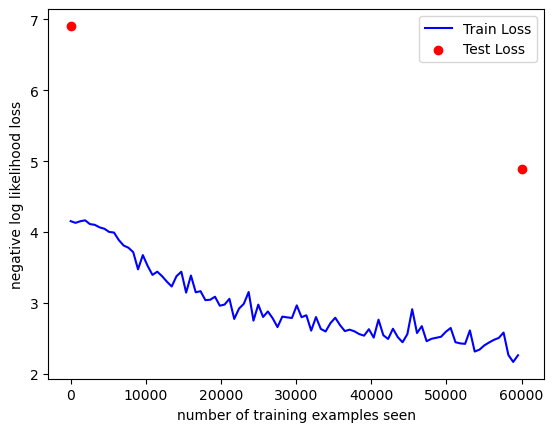

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


## Saliency gradient 

Saliency Gradient stelt de output gradient in functie van de input voor. Het vertelt ons welke pixels we het minste moeten wijzigen om het grootste verschil in output te krijgen.

Zeer makkelijk en zeer snel te berekenen. (is in essentie gewoon backpropagation éénmaal toepassen)

In [15]:
sal_grad = Saliency(network)


In [16]:
def plot_mnist(data, labels, title):
    plt.suptitle(title)
    for i in range(0,4):
        plt.subplot(1,4,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title("label: {}".format(labels[i]))
        plt.xticks([])
        plt.yticks([])

/Users/pieter/anaconda3/envs/trendsinai/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/var/folders/c2/_h0m04n573df61vwy3gp9gj40000gn/T/ipykernel_71533/2426667036.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


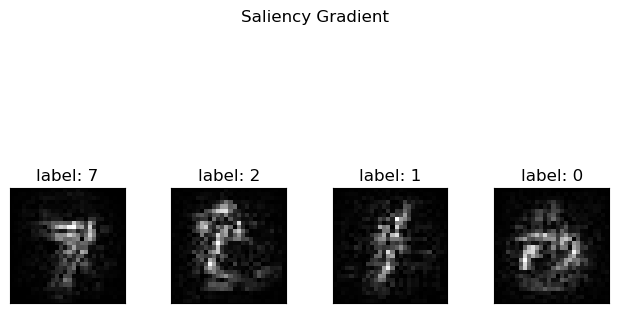

In [17]:
grad_attrs = sal_grad.attribute(example_data, target=example_targets)
plot_mnist(grad_attrs.detach().numpy(), example_targets, "Saliency Gradient")


## InputX Gradient

Input X Gradient is een uitbreiding van de Saliency Gradient. Nu worden de gradiënten van de uitvoer t.o.v. de invoer vermenigvuldigd met de feature waarde aan de invoer. We doen nu m.a.w. gradient*input, hoe sterk elke pixel bijdraagt wordt berekend, waar enkel gradient de gevoeligheid van elke pixel beschrijft.


/var/folders/c2/_h0m04n573df61vwy3gp9gj40000gn/T/ipykernel_71533/2426667036.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


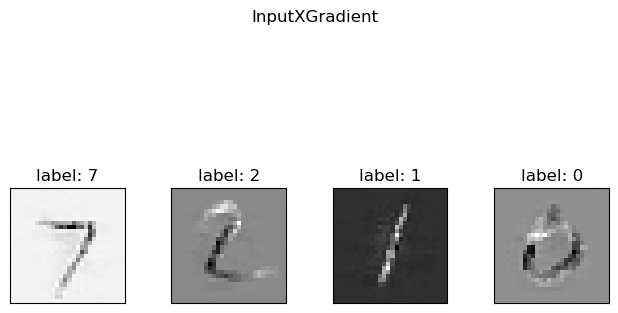

In [18]:
ixg = InputXGradient(network)

ixg_attrs = ixg.attribute(example_data, target=example_targets)
plot_mnist(ixg_attrs.detach().numpy(), example_targets, "InputXGradient")


## Integrated Gradients

Deze methode werd voor het eerst besproken in 2017, en tracht de bijdrage van elke feature aan de voorspelling nauwkeuriger te identificeren dan de meer eenvoudige gradient methoden.

Het algoritme verloopt als volgt:

- er wordt een 'baseline' gekozen, voor afbeeldingen bijvoorbeeld een volledig wit of zwart beeld
- vervolgens worden in verschillende stappen er telkens interpolaties gemaakt tussen de baseline en de eigenlijke invoer, dit wordt meestal gedaan door de baseline geleidelijk te vervangen door de eigenlijk invoer
- bij elke stap wordt de gradiënt van de uitvoer t.o.v. de invoer berekend
- dan worden de gradiënten geïntegreerd, de gradiënten van alle stappen worden opgeteld
- de berekende geïntegreerde gradiënten geven aan hoeveel elke invoerfeature heeft bijgedragen aan de uiteindelijke voorspelling van het model
- deze kunnen we dan weer makkelijk visualiseren als een heatmap

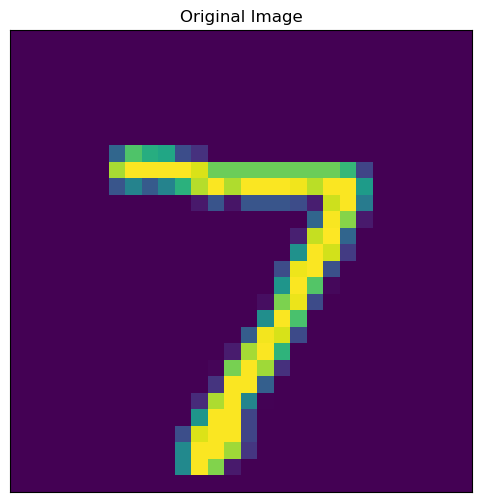

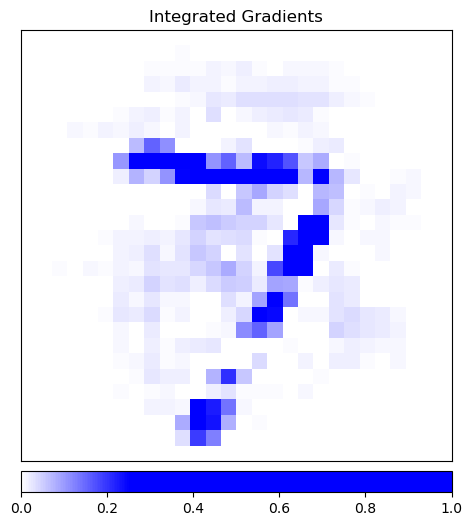

In [19]:
int_grad = IntegratedGradients(network)

attributions_ig = int_grad.attribute(example_data[:1],
                                       target=example_targets[:1],
                                       n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)
_ = viz.visualize_image_attr(None, original_image=np.transpose(example_data[:1].squeeze(axis=0).cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(axis=0).cpu().detach().numpy(), (1,2,0)),
                             original_image=np.transpose(example_data[:1].squeeze(axis=0).cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

## perturbation gebaseerd

Een andere manier om modellen te interpreteren zijn zogenaamde perturbation based attribution methodes. Het idee is om niet zozeer naar het model te kijken en dat proberen te interpreteren, maar eerder om de input aan te passen en te kijken hoe de voorspelling dan wijzigt. (deze methodes zijn m.a.w. model agnostisch)
Je vervangt een klein deel van de invoer door een grijs vierkantje, en dan kijk je hoe de voorspelling wijzigt (andere klasse, andere kans, ...), dit vierkantje verschuif je dan over de gehele afbeelding, en je bekijkt telkens het effect.

Het zal direct duidelijk zijn dat deze methode veel meer rekenkracht zal vereisen. Bovendien kan een grijs vierkantje betekenis hebben

Om deze methodes te illustreren gaan we foto's laten classificere met behulp van `resnet101` https://pytorch.org/vision/main/models/generated/torchvision.models.resnet101.html

In [3]:
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:15<00:00, 11.2MB/s] 


Ik gebruik een foto van mijn kat, Chaos.

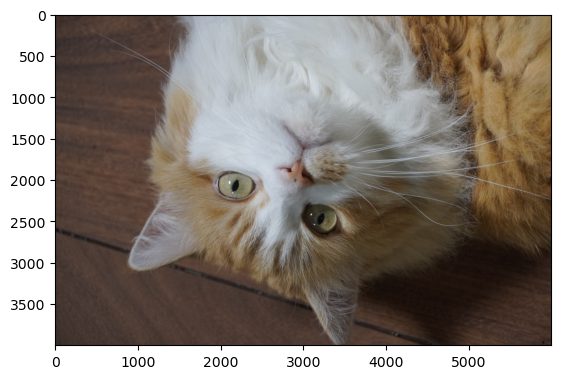

In [4]:
from PIL import Image
import json

test_img = Image.open('img/cat_chaos.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

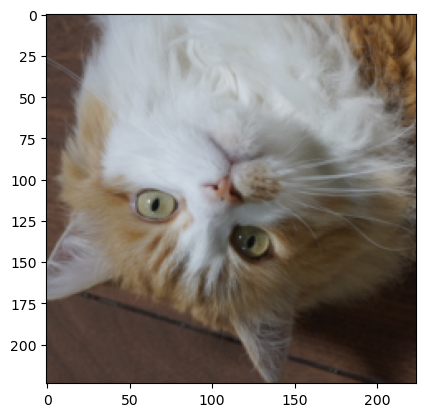

In [5]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 # transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
plt.imshow(transformed_img)
transformed_img = transforms.ToTensor()(transformed_img)

input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)



In [6]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Persian_cat ( 0.6219772696495056 )


Het is niet echt een Persische kat, maar 'close enough' als classificatie, nu kunnen we kijken waarom het model dit denkt.
Eerst passen we nogmaals de integrated gradients toe.

In [7]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to 
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx)

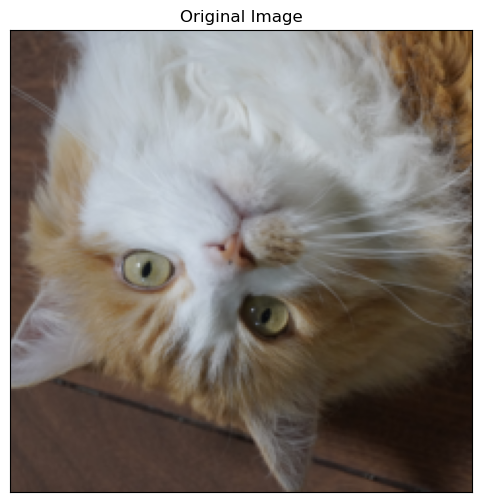

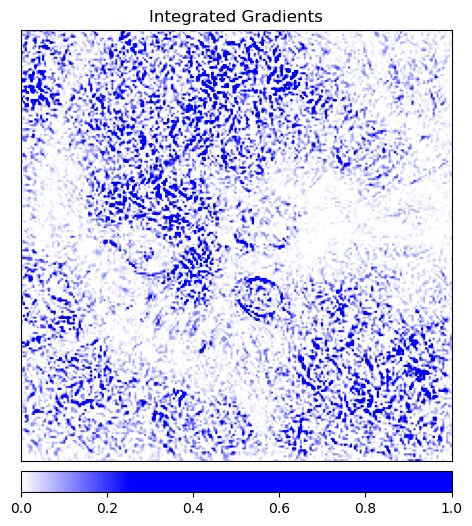

In [8]:
# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

En nu extra ook een occlusion model, dat dus een deel van de input zal 'verbergen' door een grijs vierkatje, de grootte van dit vierkant en hoeveel het verschuift elke stap kies je zelf. 
Uiteraard, hoe kleiner het vierkantje en/of hoe kleiner de stap, hoe meer rekenkracht er nodig is. (want hoe meer stappen nodig eer de volledige image 'bedekt' geweest is)

In [11]:
occlusion = Occlusion(model)



In [12]:
attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,16, 16),
                                       baselines=0, show_progress=True)

Occlusion attribution:   0%|          | 0/730 [00:00<?, ?it/s]

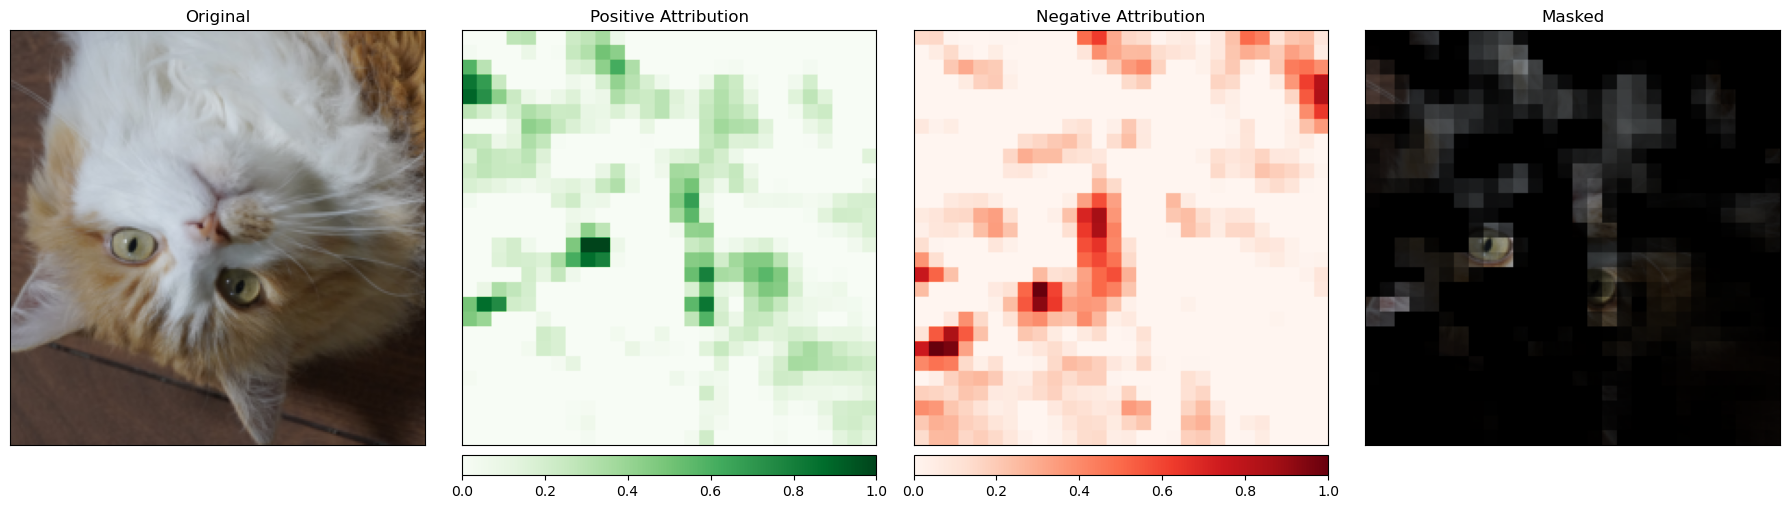

In [13]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

### oefening

Herschrijf de bovenste code in een makkelijk bruikbare methode zodat de image manipulatie (schaling) en toepassen van de occlusion en integrated gradients op een andere foto kunnen toegepast worden.

Als voorbeeld nemen we de kat Noor, van mevrouw Cornette.

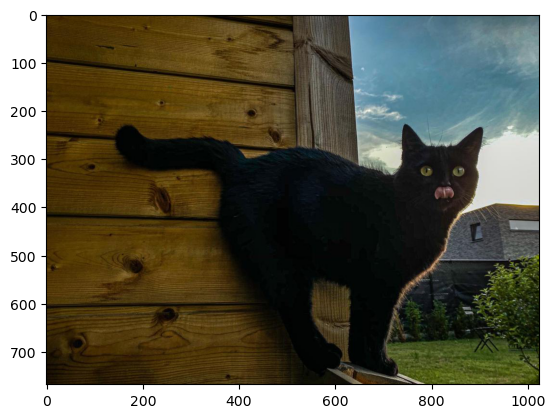

In [29]:

test_img2 = Image.open('img/cat_noor.jpeg')
test_img_data2 = np.asarray(test_img2)
plt.imshow(test_img_data2)
plt.show()